In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../build/lib.linux-x86_64-3.6')
sys.path.append('../thirdparty/opencv/lib')
%matplotlib inline
import blobextractor
import pandas as pd
import time

3.3.0


In [2]:
from test_blobextractor import TestBeeTrackTracker
test=TestBeeTrackTracker()
 

In [3]:
mask,background = test.get_maskbackground()
blob, blob_center, blob_axes, blob_angle = test.get_randomblob(mask,background)
print(blob_center,blob_axes,blob_angle)

[1178  353] [68 32] 82.9289110039


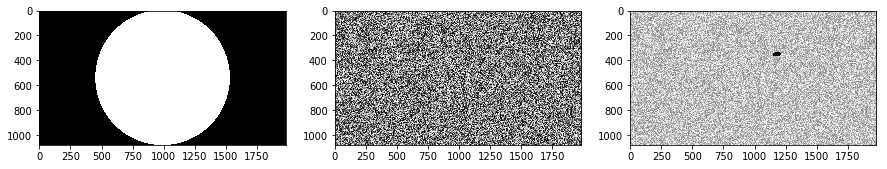

In [4]:
f,axarr=plt.subplots(1,3,figsize=(15,4))
for i, image in enumerate([mask,background,blob]):
    ax=axarr[i]
    ax.imshow(image,cmap=plt.get_cmap('gray'))

14.01216330650792 Hz


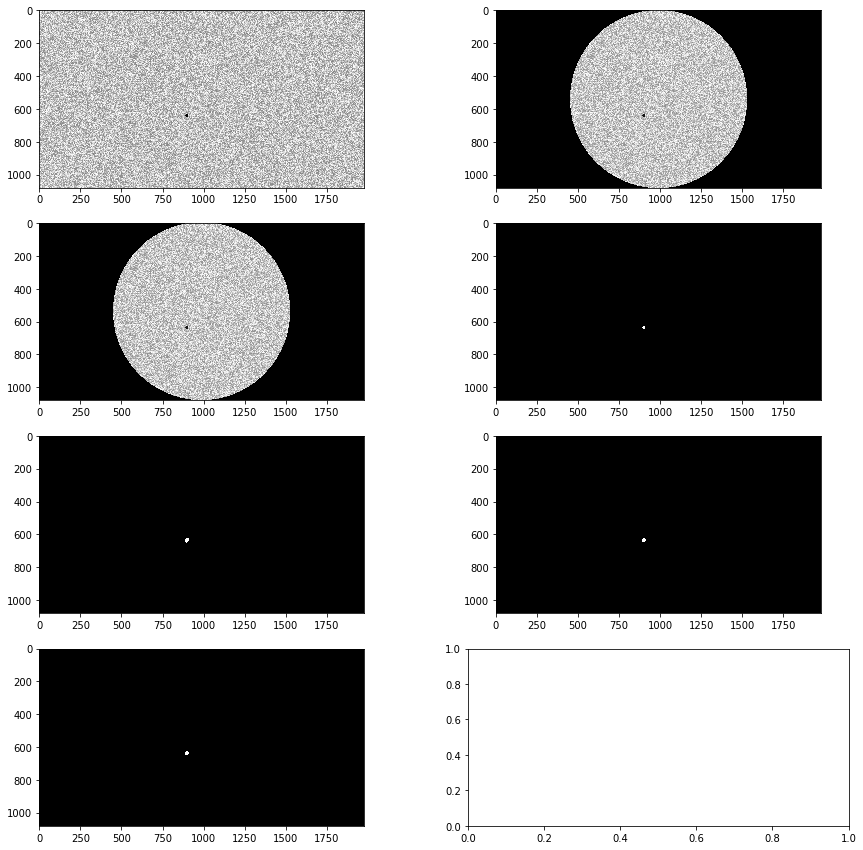

In [5]:
mybee=blobextractor.BlobFinder(mask)
mybee.gaussian_blur=1
mybee.area_lim=[0,10000]
mybee.roundness_lim=[0,1]
mybee.erode_iter=1
mybee.dilate_iter=3
mybee.run(background)

max_error_pos=1 #px
max_angle_pos=1 #deg
max_simulated_blob=1

for _ in range(50):
    blob, blob_center, blob_axes, blob_angle = test.get_randomblob(mask,background)
    mybee.run(blob)
    
blobs=pd.DataFrame(index=np.arange(100),columns=['x','y','h','w','angle'],dtype=np.float)
detections=np.nan*blobs.copy()
t_start=time.time()
for frame_i in blobs.index:
    blob, blob_center, blob_axes, blob_angle = test.get_randomblob(mask,background)
    blobs.loc[frame_i,['x','y']]=blob_center
    blobs.loc[frame_i,['h','w']]=blob_axes
    blobs.loc[frame_i,['angle']]=blob_angle
    
    mybee.run(blob)
    contours=mybee.filtered_contours
    if len(contours) != 1:
        print('More than one contours detected')
    contours=contours[0]
    detections.loc[frame_i,['x','y']]=contours[0]
    detections.loc[frame_i,['h','w']]=contours[1]
    detections.loc[frame_i,['angle']]=contours[2]
    
    #if contours.shape[0]>max_simulated_blob:
    #    raise ValueError('Too many blobs detected')
    #elif contours.shape[0]<max_simulated_blob:
    #    raise ValueError('Too few blobs detected')
    
    px_error=np.sqrt(np.sum(contours[0]-blob_center)**2)
    assert (px_error<max_error_pos), 'pixel error is too large {}>{}'.format(px_error,max_error_pos)
    angle_error=np.sqrt(np.sum(contours[2]-blob_angle)**2)
    #assert (angle_error<max_angle_pos), 'angle error is too large {}>{}'.format(angle_error,max_angle_pos)
t_end=time.time()
t_elapsed=t_end-t_start
frame_per_sec=blobs.shape[0]/t_elapsed
print(frame_per_sec, 'Hz')

f,axarr=plt.subplots(4,2,figsize=(15,15))
axarr=axarr.flatten()
for i, myim in enumerate([mybee.original_image,
                          mybee.masked_image,
                          mybee.blured_image,
                          mybee.segmented_image,
                          mybee.dilated_image,
                          mybee.eroded_image,
                          mybee.processed_image]):
    ax=axarr[i]
    ax.imshow(myim,cmap=plt.get_cmap('gray'))

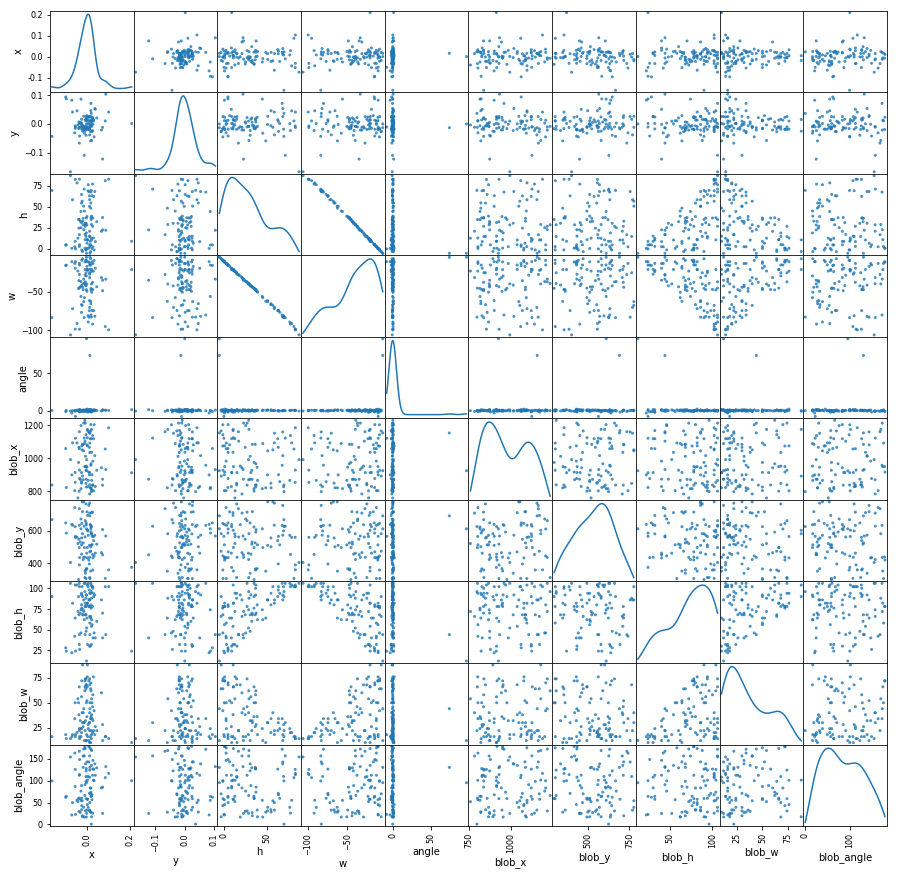

In [6]:
from pandas.plotting import scatter_matrix
df=blobs-detections
for col in blobs.columns:
    df['blob_'+col]=blobs.loc[:,col]
df=df.dropna()
scatter_matrix(df, alpha=0.8, figsize=(15, 15), diagonal='kde');

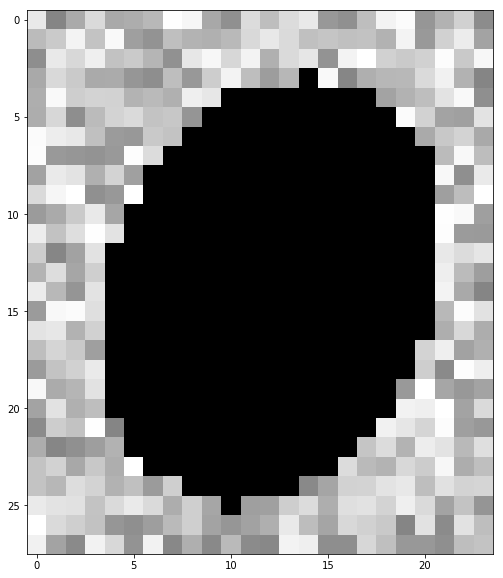

In [11]:
croper=blobextractor.BlobCroper()
croped_images=croper.crop(mybee.original_image,mybee.filtered_contours)
f,axarr=plt.subplots(1,min(4,len(croped_images)),figsize=(10,10))
if not isinstance(axarr,list):
    axarr=[axarr]
for i in range(len(axarr)):
    ax=axarr[i]
    ax.imshow(croped_images[i],cmap=plt.get_cmap('gray'))